In [ ]:
!pip install torch torchvision
!pip install opencv-python
!pip install yolov5
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.5/953.5 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 128.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.

In [45]:
!pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt



In [132]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing the Dependencies

In [133]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [134]:
%matplotlib inline
import os
import glob
import pandas as pd
import numpy as np
import gymnasium as gym
from gym import spaces
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from scipy.stats import entropy
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import average_precision_score
from pathlib import Path
from IPython.display import clear_output
import random
from collections import deque
import copy

In [135]:

# Model
model = th.hub.load("ultralytics/yolov5", "yolov5s", pretrained = True)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-8-23 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Adding AutoShape... 


# The custom Gym Environment

In [136]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

class ImagePreprocessorEnv(gym.Env):

    def __init__(self, img_dir , yolo_v5_model , steps = 5):
        super().__init__()

        # Storing the input args
        self.img_dir = img_dir
        self.yolo_v5_model = yolo_v5_model
        self.steps = steps
        self.current_image_index = 0
        self.processed_image = None

        # Loading all image file paths
        self.img_paths = glob.glob(os.path.join(self.img_dir, '*.jpg'))

        self.observation_space = spaces.Box(
            low=np.array([0.0] * 3), # Brightness Contrast and Sharpness
            high=np.array([1.0] * 3),
            dtype=np.float32
        )

        #  action space
        self.action_space = spaces.Box(
            low=np.array([-1.0, -1.0, 0.0]), # Tuning the  Brightness, Contrast and Sharpness
            high=np.array([1.0, 1.0, 1.0]),
            dtype=np.float32
        )


    def reset(self):

        self.current_step = 0
        self.yolo_v5_model.eval()

        # Select the image each episode
        img_path = self.img_paths[self.current_image_index]
        self.current_image_index = (self.current_image_index + 1) % len(self.img_paths)

        self.original_image = cv.imread(img_path)
        self.original_image = cv.cvtColor(self.original_image, cv.COLOR_BGR2RGB)

        # initial processed = original
        self.processed_image = self.original_image.copy()
        self.last_conf = self.confidence(self.processed_image)

        obs = self._get_observation()
        return obs


    @staticmethod
    def normalize_val(value , min = 0 , max = 255):
        return np.clip((value - min) / (max - min), 0.0, 1.0)


    def _get_observation(self):
        gray_image = cv.cvtColor(self.processed_image, cv.COLOR_RGB2GRAY)

        # Get the observation features
        brightness = np.mean(gray_image) # mean brightness

        contrast = np.std(gray_image)  # Difference in contrast

        sharpness = cv.Laplacian(gray_image, cv.CV_64F).var() # Sharpness using variance of Laplacian

        # Normalize features
        obs = np.array([
            self.normalize_val(brightness),
            self.normalize_val(contrast, 0 , 64),
            self.normalize_val(sharpness, 0, 1000),
        ], dtype=np.float32)

        return obs


    def confidence(self, image):

        # The result of Yolov5s detection on the passed image
        results = self.yolo_v5_model(image)

        # If None
        if results.pred[0].shape[0] == 0:
            return 0.0
        confs = results.pred[0][:, 4].cpu().numpy()

        k = min(3, len(confs))  # top 3 objects, for example
        return float(np.sum(np.sort(confs)[-k:]))



    def transform(self, image, action):

        img = Image.fromarray(image)

        brightness_factor = 1.0 + action[0]
        img = ImageEnhance.Brightness(img).enhance(brightness_factor)

        contrast_factor = 1.0 + action[1]
        img = ImageEnhance.Contrast(img).enhance(contrast_factor)

        img_np = np.array(img)

        blur_strength = float(action[2])
        if blur_strength > 0:
            sigma = blur_strength * 0.5
            img_np = cv.GaussianBlur(img_np, (0, 0), sigmaX=sigma)

        return img_np


    def reward_function(self, old_conf, new_conf):
        return (new_conf - old_conf) + 0.05 * (new_conf)


    def step(self, action):
        old_conf = self.last_conf
        self.processed_image = self.transform(self.processed_image, action)

        new_conf = self.confidence(self.processed_image)

        # reward
        reward = self.reward_function(old_conf, new_conf)
        self.last_conf = new_conf

        obs = self._get_observation()

        # done flag
        self.current_step += 1
        done = self.current_step >= self.steps

        info = {
            "old_confidence": old_conf,
            "new_confidence": new_conf,
            "step": self.current_step
        }

        return obs, reward, done, info


    def render(self , image):
        plt.imshow(image)
        plt.axis('off')
        plt.show()

cuda


# Actor Critic Network

In [137]:
class Actor(nn.Module):

    def __init__(self, no_states, no_actions):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(no_states, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128,no_actions)
        )

        # O/P activation fn
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.to(device)

    def forward(self, state):
        state = state.to(device)
        out = self.network(state)

        # Applying the activation fn to the outputs
        brightness = self.tanh(out[:, 0:1])
        contrast = self.tanh(out[:, 1:2])
        blur = self.sigmoid(out[:, 2:3])

        # Concatenate the final action vector
        action = th.cat([brightness, contrast, blur], dim=1)
        return action


class Critic(nn.Module):
    def __init__(self, no_states, no_actions):
        super().__init__()

        self.fc1 = nn.Linear(no_states, 256)
        self.fc2 = nn.Linear(256 + no_actions, 256)

        # Q-value output n/w
        self.q_out = nn.Linear(256, 1)
        self.to(device)

    def forward(self, state, action):
        state = state.to(device)
        state_out = F.relu(self.fc1(state))

        x = th.cat([state_out, action], dim=1)
        x = F.relu(self.fc2(x))

        q_value = self.q_out(x)
        return q_value

In [138]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size, device):
        transitions = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*transitions)

        return (
            th.FloatTensor(states).to(device),
            th.FloatTensor(actions).to(device),
            th.FloatTensor(rewards).unsqueeze(1).to(device),
            th.FloatTensor(next_states).to(device),
            th.FloatTensor(dones).unsqueeze(1).to(device),
        )

    def __len__(self):
        return len(self.buffer)


In [139]:
def soft_update(target_net, source_net, tau=0.005):
    for target_param, source_param in zip(target_net.parameters(), source_net.parameters()):
        target_param.data.copy_(tau * source_param.data + (1.0 - tau) * target_param.data)

In [127]:
# CONSTANTS
GAMMA = 0.99 # Discount Factor
TAU = 0.005 # Soft Update parameter
BATCH_SIZE = 256 # Size of batch for replay buffer
MAX_EPISODES = 1820 # Number of images to train
MAX_STEPS = 7
WARMUP_STEPS = 200
SEED = 13


# Hyperparameters
initial_noise = 0.5
final_noise = 0.05
updates_per_step = 3  # do multiple gradient updates per step
rolling_window = 100     # smoothing window
policy_noise = 0.2
noise_clip = 0.5
policy_delay = 2   # update actor every 2 critic updates

random.seed(SEED)          # Python RNG
np.random.seed(SEED)       # NumPy RNG
th.manual_seed(SEED)       # PyTorch RNG


In [128]:
img_directory = "/content/drive/MyDrive/Atri Dataset/Train"

# Initializing the Env
env = ImagePreprocessorEnv(img_directory, model)
no_states = env.observation_space.shape[0]
no_actions = env.action_space.shape[0]

# Creating the Actor and Critic Networks

actor = Actor(no_states, no_actions)
target_actor = Actor(no_states, no_actions).to(device)
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)

critic1 = Critic(no_states, no_actions).to(device)
critic2 = Critic(no_states, no_actions).to(device)
target_critic1 = Critic(no_states, no_actions).to(device)
target_critic2 = Critic(no_states, no_actions).to(device)

critic1_optimizer = th.optim.Adam(critic1.parameters(), lr=3e-4)
critic2_optimizer = th.optim.Adam(critic2.parameters(), lr=3e-4)

# Copy params
target_actor.load_state_dict(actor.state_dict())
target_critic1.load_state_dict(critic1.state_dict())
target_critic2.load_state_dict(critic2.state_dict())

replay_buffer = ReplayBuffer(100000)

In [129]:
def add_noise(action, sigma=0.1):
    noise =  np.random.normal(0, sigma, size=action.shape)

    # Clip actions to valid range
    action = np.clip(action + noise , [-1.0, -1.0, 0.0], [1.0, 1.0, 1.0])
    return action

# Training Loop

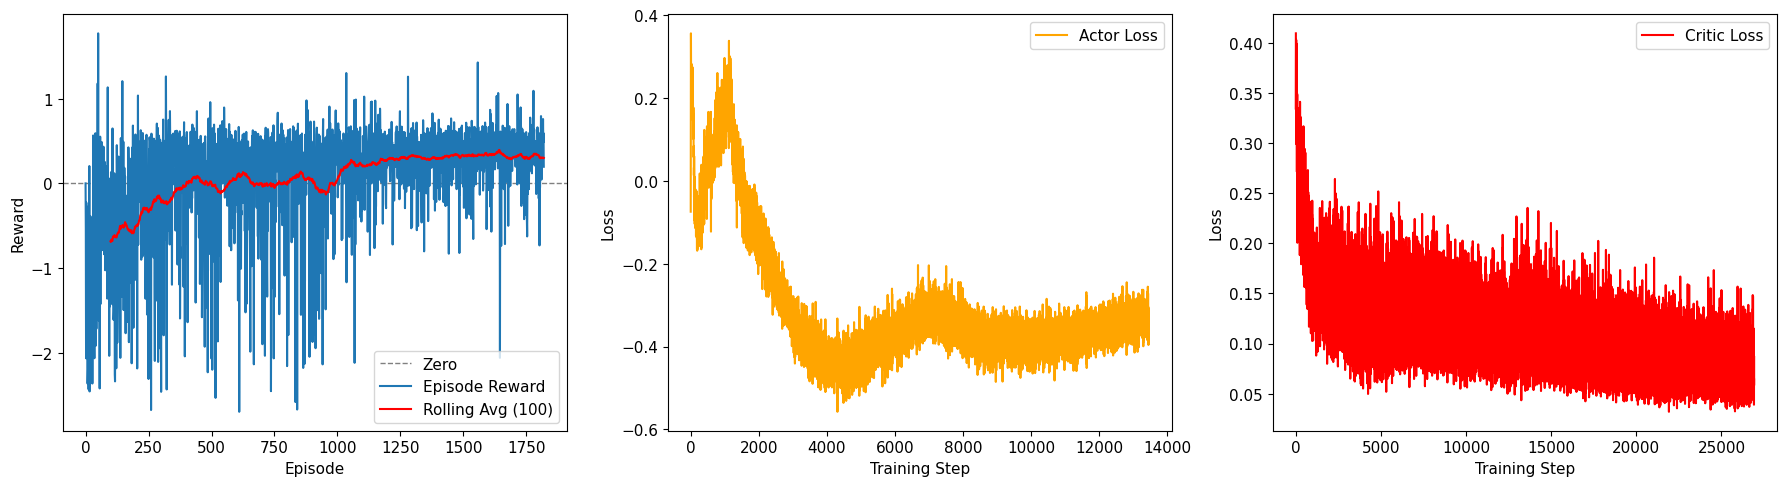

Simple DDPG Training Completed!


In [130]:
total_updates = 0
episode_rewards_list = []
actor_losses_list = []
critic_losses_list = []
total_steps = 0
noise_decay = (initial_noise - final_noise) / MAX_EPISODES

# Training loop using TD3
for episode in range(MAX_EPISODES):

    # Get the state variables
    state = env.reset()
    episode_reward = 0

    print(f"Episode {episode+1}/{MAX_EPISODES}")

    for step in range(MAX_STEPS):

        total_steps += 1
        if total_steps < WARMUP_STEPS:
            action = env.action_space.sample()
        else:

            # Get action for current state
            with th.no_grad():
                state_tensor = th.FloatTensor(state).unsqueeze(0).to(device)
                action = actor(state_tensor).cpu().numpy()[0]

            noise = max(final_noise, initial_noise - episode * noise_decay)

            # Add noise
            action = add_noise(action, noise)
        next_state, reward, done, info = env.step(action)

        # Store in replay buffer
        replay_buffer.add(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward


        if len(replay_buffer) > BATCH_SIZE:
            for g in range(updates_per_step):
                total_updates += 1

                states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE, device)

                with th.no_grad():
                    # Target policy smoothing
                    noise = (th.randn_like(actions) * policy_noise).clamp(-noise_clip, noise_clip)
                    next_actions = (target_actor(next_states) + noise).clamp(-1, 1)

                    # Compute target Q
                    target_Q1 = target_critic1(next_states, next_actions)
                    target_Q2 = target_critic2(next_states, next_actions)
                    target_Q = th.min(target_Q1, target_Q2)
                    target_Q = rewards + GAMMA * (1 - dones) * target_Q

                # Update critics
                current_Q1 = critic1(states, actions)
                current_Q2 = critic2(states, actions)

                critic1_loss = F.mse_loss(current_Q1, target_Q)
                critic2_loss = F.mse_loss(current_Q2, target_Q)

                critic1_optimizer.zero_grad()
                critic1_loss.backward()
                critic1_optimizer.step()

                critic2_optimizer.zero_grad()
                critic2_loss.backward()
                critic2_optimizer.step()
                critic_losses_list.append(min(critic1_loss.item() , critic2_loss.item()))


                # Actor updates
                if total_updates % policy_delay == 0:
                    actor_loss = -critic1(states, actor(states)).mean()
                    actor_optimizer.zero_grad()
                    actor_loss.backward()
                    actor_optimizer.step()
                    actor_losses_list.append(actor_loss.item())

                    # Soft update target networks
                    soft_update(target_actor, actor, TAU)
                    soft_update(target_critic1, critic1, TAU)
                    soft_update(target_critic2, critic2, TAU)

        if done:
            break

    # Store rewards
    episode_rewards_list.append(episode_reward)

    # Live Plot
    clear_output(wait=True)
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.axhline(y=0.0, color='gray', linestyle='--', linewidth=1, label='Zero')
    plt.plot(episode_rewards_list, label='Episode Reward')
    if len(episode_rewards_list) >= rolling_window:
        rewards_rolling = pd.Series(episode_rewards_list).rolling(rolling_window).mean()
        plt.plot(rewards_rolling, label=f'Rolling Avg ({rolling_window})', color='red')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(actor_losses_list, label='Actor Loss', color='orange')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(critic_losses_list, label='Critic Loss', color='red')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

print("Simple DDPG Training Completed!")



In [131]:
 # Save Path
save_path = "/content/drive/MyDrive/actor_critic/"
os.makedirs(save_path, exist_ok=True)

# Save models
th.save(actor.state_dict(), os.path.join(save_path, "actor_new_final_mini128.pth"))
th.save(critic1.state_dict(), os.path.join(save_path, "critic1_new_final_mini128.pth"))
th.save(critic2.state_dict(), os.path.join(save_path, "critic2_new_final_mini128.pth"))

print("Models saved to Google Drive:", save_path)

Models saved to Google Drive: /content/drive/MyDrive/actor_critic/


# Validation Code

In [71]:
# Create actor for eval
actor = Actor(3, 3).to(device)

# Load weights safely for CPU
checkpoint = th.load("/content/drive/MyDrive/actor_critic/actor_new_final.pth", map_location=device)
actor.load_state_dict(checkpoint)

actor.eval()



Actor(
  (network): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
  (tanh): Tanh()
  (sigmoid): Sigmoid()
)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-8-23 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Adding AutoShape... 


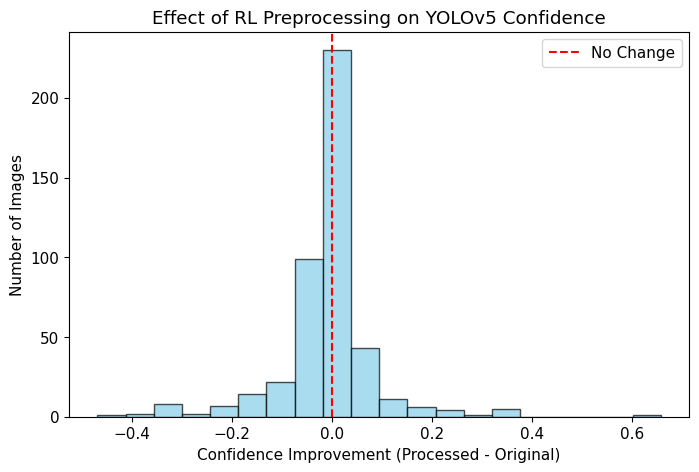

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


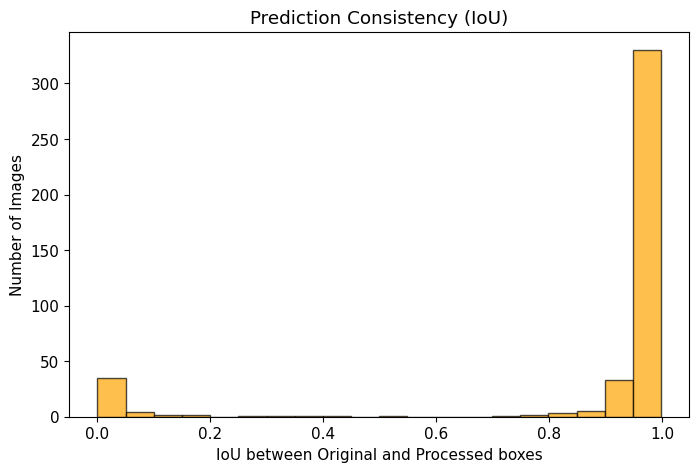

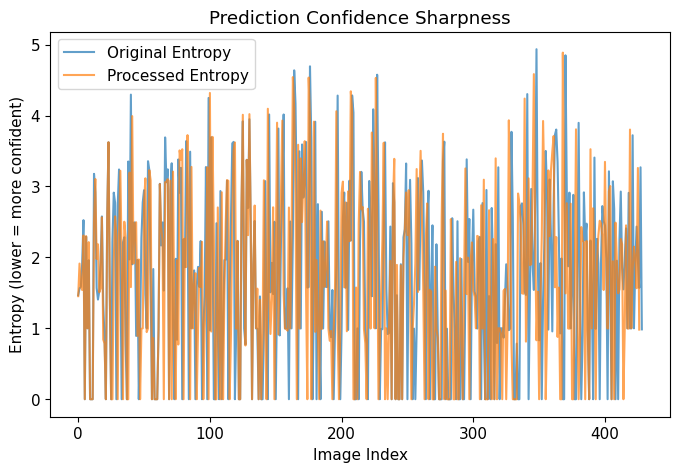

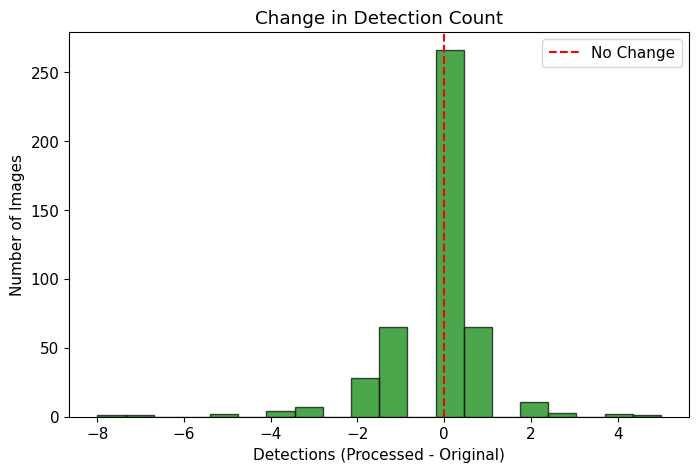

In [72]:

model = th.hub.load("ultralytics/yolov5", "yolov5s", pretrained=True)
model.eval()

test_dir = r"/content/drive/MyDrive/Atri Dataset/Test"

# Lists for Validation Graphs
all_conf_diffs = []
iou_consistency = []
entropy_orig_list, entropy_proc_list = [], []
detections_diff = []

for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)

    # Create a new environment for each class's images
    env_eval = ImagePreprocessorEnv(class_path, model, steps=MAX_STEPS)

    # For test image
    for fname in os.listdir(class_path):

        img_path = os.path.join(class_path, fname)
        img = cv.imread(img_path)
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        # Prepare state
        state = env_eval.reset()
        state_tensor = th.FloatTensor(state).unsqueeze(0)

        # Actor predicts action
        with th.no_grad():
            action = actor(state_tensor).cpu().numpy()[0]

        # Apply transformation using env
        img_proc = env_eval.transform(img_rgb, action)

        results_orig = model(img_rgb)
        results_proc = model(img_proc)

        pred_orig = results_orig.pred[0].cpu().numpy()
        pred_proc = results_proc.pred[0].cpu().numpy()

        # Confidence diff
        confs_orig = pred_orig[:, 4] if pred_orig.size > 0 else []
        confs_proc = pred_proc[:, 4] if pred_proc.size > 0 else []
        mean_orig = np.mean(confs_orig) if len(confs_orig) > 0 else 0
        mean_proc = np.mean(confs_proc) if len(confs_proc) > 0 else 0
        all_conf_diffs.append(mean_proc - mean_orig)

        #  IoU consistency
        if len(pred_orig) > 0 and len(pred_proc) > 0:

            # Take top prediction
            box_o = pred_orig[0][:4]
            box_p = pred_proc[0][:4]

            # IoU calculation
            xA = max(box_o[0], box_p[0])
            yA = max(box_o[1], box_p[1])
            xB = min(box_o[2], box_p[2])
            yB = min(box_o[3], box_p[3])
            interArea = max(0, xB - xA) * max(0, yB - yA)
            boxAArea = (box_o[2] - box_o[0]) * (box_o[3] - box_o[1])
            boxBArea = (box_p[2] - box_p[0]) * (box_p[3] - box_p[1])
            iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
            iou_consistency.append(iou)

        #  Entropy of class probabilities
        if len(pred_orig) > 0:
            probs_o = pred_orig[:, 4] / np.sum(pred_orig[:, 4])  # normalize
            entropy_orig_list.append(entropy(probs_o, base=2))
        if len(pred_proc) > 0:
            probs_p = pred_proc[:, 4] / np.sum(pred_proc[:, 4])
            entropy_proc_list.append(entropy(probs_p, base=2))

        # Detection count change
        detections_diff.append(len(pred_proc) - len(pred_orig))

# Confidence diff histogram
plt.figure(figsize=(8, 5))
plt.hist(all_conf_diffs, bins=20, color="skyblue", edgecolor="black", alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label="No Change")
plt.xlabel("Confidence Improvement (Processed - Original)")
plt.ylabel("Number of Images")
plt.title("Effect of RL Preprocessing on YOLOv5 Confidence")
plt.legend()
plt.show()

# IoU consistency distribution
plt.figure(figsize=(8, 5))
plt.hist(iou_consistency, bins=20, color="orange", edgecolor="black", alpha=0.7)
plt.xlabel("IoU between Original and Processed boxes")
plt.ylabel("Number of Images")
plt.title("Prediction Consistency (IoU)")
plt.show()

# Entropy before vs after
plt.figure(figsize=(8, 5))
plt.plot(entropy_orig_list, label="Original Entropy", alpha=0.7)
plt.plot(entropy_proc_list, label="Processed Entropy", alpha=0.7)
plt.xlabel("Image Index")
plt.ylabel("Entropy (lower = more confident)")
plt.title("Prediction Confidence Sharpness")
plt.legend()
plt.show()

# Detection count difference
plt.figure(figsize=(8, 5))
plt.hist(detections_diff, bins=20, color="green", edgecolor="black", alpha=0.7)
plt.axvline(0, color='red', linestyle="--", label="No Change")
plt.xlabel("Detections (Processed - Original)")
plt.ylabel("Number of Images")
plt.title("Change in Detection Count")
plt.legend()
plt.show()


['/content/drive/MyDrive/Image_dir/bike]/bike.JPG']
['/content/drive/MyDrive/Image_dir/bike]/bike.JPG']
/content/drive/MyDrive/Image_dir/bike]
['/content/drive/MyDrive/Image_dir/bike]/bike.JPG']
[   0.049879    0.099051    0.063311]


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


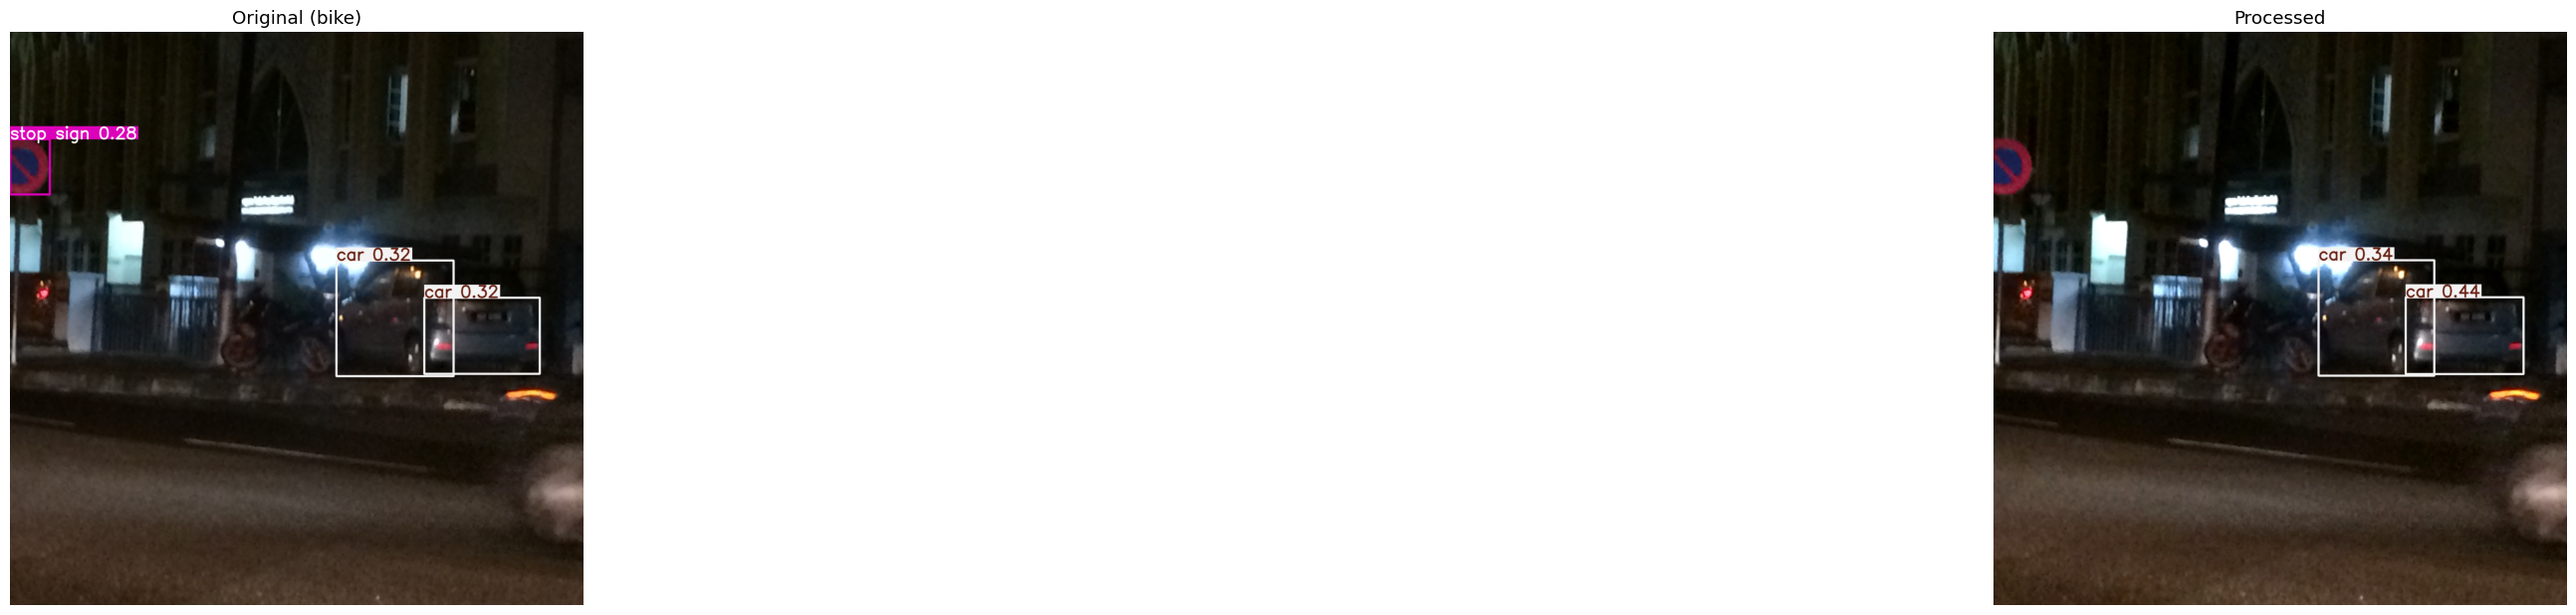

In [ ]:
import random

test_dir = r"/content/drive/MyDrive/Image_dir"

# Collect all test images
all_images = []
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.jpg')):
                all_images.append(os.path.join(class_path, fname))

print(all_images)

# Pick 5 random images
sample_paths = random.sample(all_images, 1)

print(sample_paths)

plt.figure(figsize=(40, 30))

for i, img_path in enumerate(sample_paths):
    class_path = os.path.dirname(img_path)
    print(class_path)
    env_eval = ImagePreprocessorEnv(class_path, model, steps=MAX_STEPS)

    # Load image
    img = cv.imread(img_path)
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    # RL Agent processing
    state = env_eval.reset()
    state_tensor = th.FloatTensor(state).unsqueeze(0)
    with th.no_grad():
        action = actor(state_tensor).cpu().numpy()[0]
    print(action)
    img_proc = env_eval.transform(img_rgb, action)

    # Run YOLO
    results_orig = model(img_rgb)
    results_proc = model(img_proc)

    # Annotated images
    orig_annot = np.squeeze(results_orig.render())
    proc_annot = np.squeeze(results_proc.render())

    # Grid plotting
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(orig_annot)
    plt.axis("off")
    plt.title(f"Original ({Path(img_path).stem})")

    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(proc_annot)
    plt.axis("off")
    plt.title("Processed")

plt.tight_layout()
plt.show()
